In [ ]:
!pip install scvi-tools -U
!pip install scanpy
!pip3 install leidenalg
#!pip install git+https://github.com/theislab/scvelo
#!pip install cellrank
#!pip install harmonypy

     |████████████████████████████████| 231 kB 8.0 MB/s 
     |████████████████████████████████| 678 kB 55.2 MB/s 
     |████████████████████████████████| 813 kB 66.8 MB/s 
     |████████████████████████████████| 242 kB 67.3 MB/s 
     |████████████████████████████████| 127 kB 72.8 MB/s 
     |████████████████████████████████| 212 kB 73.6 MB/s 
     |████████████████████████████████| 282 kB 80.7 MB/s 
     |████████████████████████████████| 829 kB 77.1 MB/s 
     |████████████████████████████████| 636 kB 59.4 MB/s 
     |████████████████████████████████| 125 kB 78.1 MB/s 
     |████████████████████████████████| 1.3 MB 78.0 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
     |████████████████████████████████| 160 kB 72.5 MB/s 
     |████████████████████████████████| 271 kB 75.0 MB/s 
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19895 sha256=73faa02ef4c692f61de11f623cda4e57a185743321a45ac3a0508d15bf4af753
  Stored in directory: /root/.cache/pip/w

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import anndata
import seaborn as sns
import matplotlib as mpl
import scvi
#import scvelo as scv
#import cellrank as cr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#first cluster the complete dataset on a combined UMAP
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
gca = sc.read_h5ad('GCA_filtered.h5ad')

gca.var['mt'] = gca.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
gca.var['ribo'] = gca.var_names.str.startswith(('RPS', 'RPL'))
sc.pp.calculate_qc_metrics(gca, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

gca = gca[gca.obs.pct_counts_mt < 20, :]

In [ ]:
gca.layers["counts"] = gca.X.copy()

In [ ]:
sc.pp.normalize_total(gca, target_sum=1e4)
sc.pp.log1p(gca)

gca.raw = gca

sc.pp.highly_variable_genes(
    gca,
    n_top_genes=3000,
    subset=True,
    flavor="seurat",
    batch_key="tissue")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
scvi.data.setup_anndata(
    gca,
    layer="counts",
    categorical_covariate_keys=["sample_id"],
    continuous_covariate_keys=["pct_counts_mt"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 157607 cells, 3000 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
model_gca = scvi.model.SCVI(gca)
model_gca.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51/51: 100%|██████████| 51/51 [12:18<00:00, 14.49s/it, loss=261, v_num=1]


In [ ]:
latent = model.get_latent_representation()
gca.obsm["X_scVI"] = latent

gca.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

sc.pp.neighbors(gca, use_rep="X_scVI", n_neighbors=30)
sc.tl.umap(gca, min_dist = 0.4)

In [ ]:
sc.tl.umap(gca, min_dist = 0.2)

In [ ]:
#add combined annotation

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
blood_anno = pd.read_csv('blood_clustering.csv', index_col = 0)
tissue_anno = pd.read_csv('tissue_clustering.csv', index_col = 0)

blood_anno.columns = ['anno']
tissue_anno.columns = ['anno']

blood_anno['anno'] = blood_anno.anno.astype(str) + '_blood'
tissue_anno['anno'] = tissue_anno.anno.astype(str) + '_tissue'

anno = blood_anno.append(tissue_anno)

gca.obs = gca.obs.merge(anno, how = 'left', left_index = True, right_index = True)

gca.obs.anno = gca.obs.anno.astype('category')

In [ ]:
gca.write('gca_scVI.h5ad', compression = 'gzip')

In [ ]:
***********Restart****

In [ ]:
#Restart tissue and blood 

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets') 
gca = sc.read_h5ad('gca_scVI.h5ad') 
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data') 
model = scvi.model.SCVI.load("full_scVI_model_v4/", gca, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 157607 cells, 3000 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 1 extra continuous covariates.                                                  


In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/')
colours = pd.read_csv('colours.csv', index_col = 0)

In [ ]:
gca_filtered = gca[gca.obs.anno !=('Doublet_tissue'),:]

In [ ]:
#reorder categories using colour csv

gca_filtered.obs.anno = gca_filtered.obs.anno.cat.reorder_categories(colours.anno.tolist())

Trying to set attribute `.obs` of view, copying.


In [ ]:
#colour categories using colour csv

gca_filtered.uns['anno_colors'] = np.array(colours.colors.array).tolist()

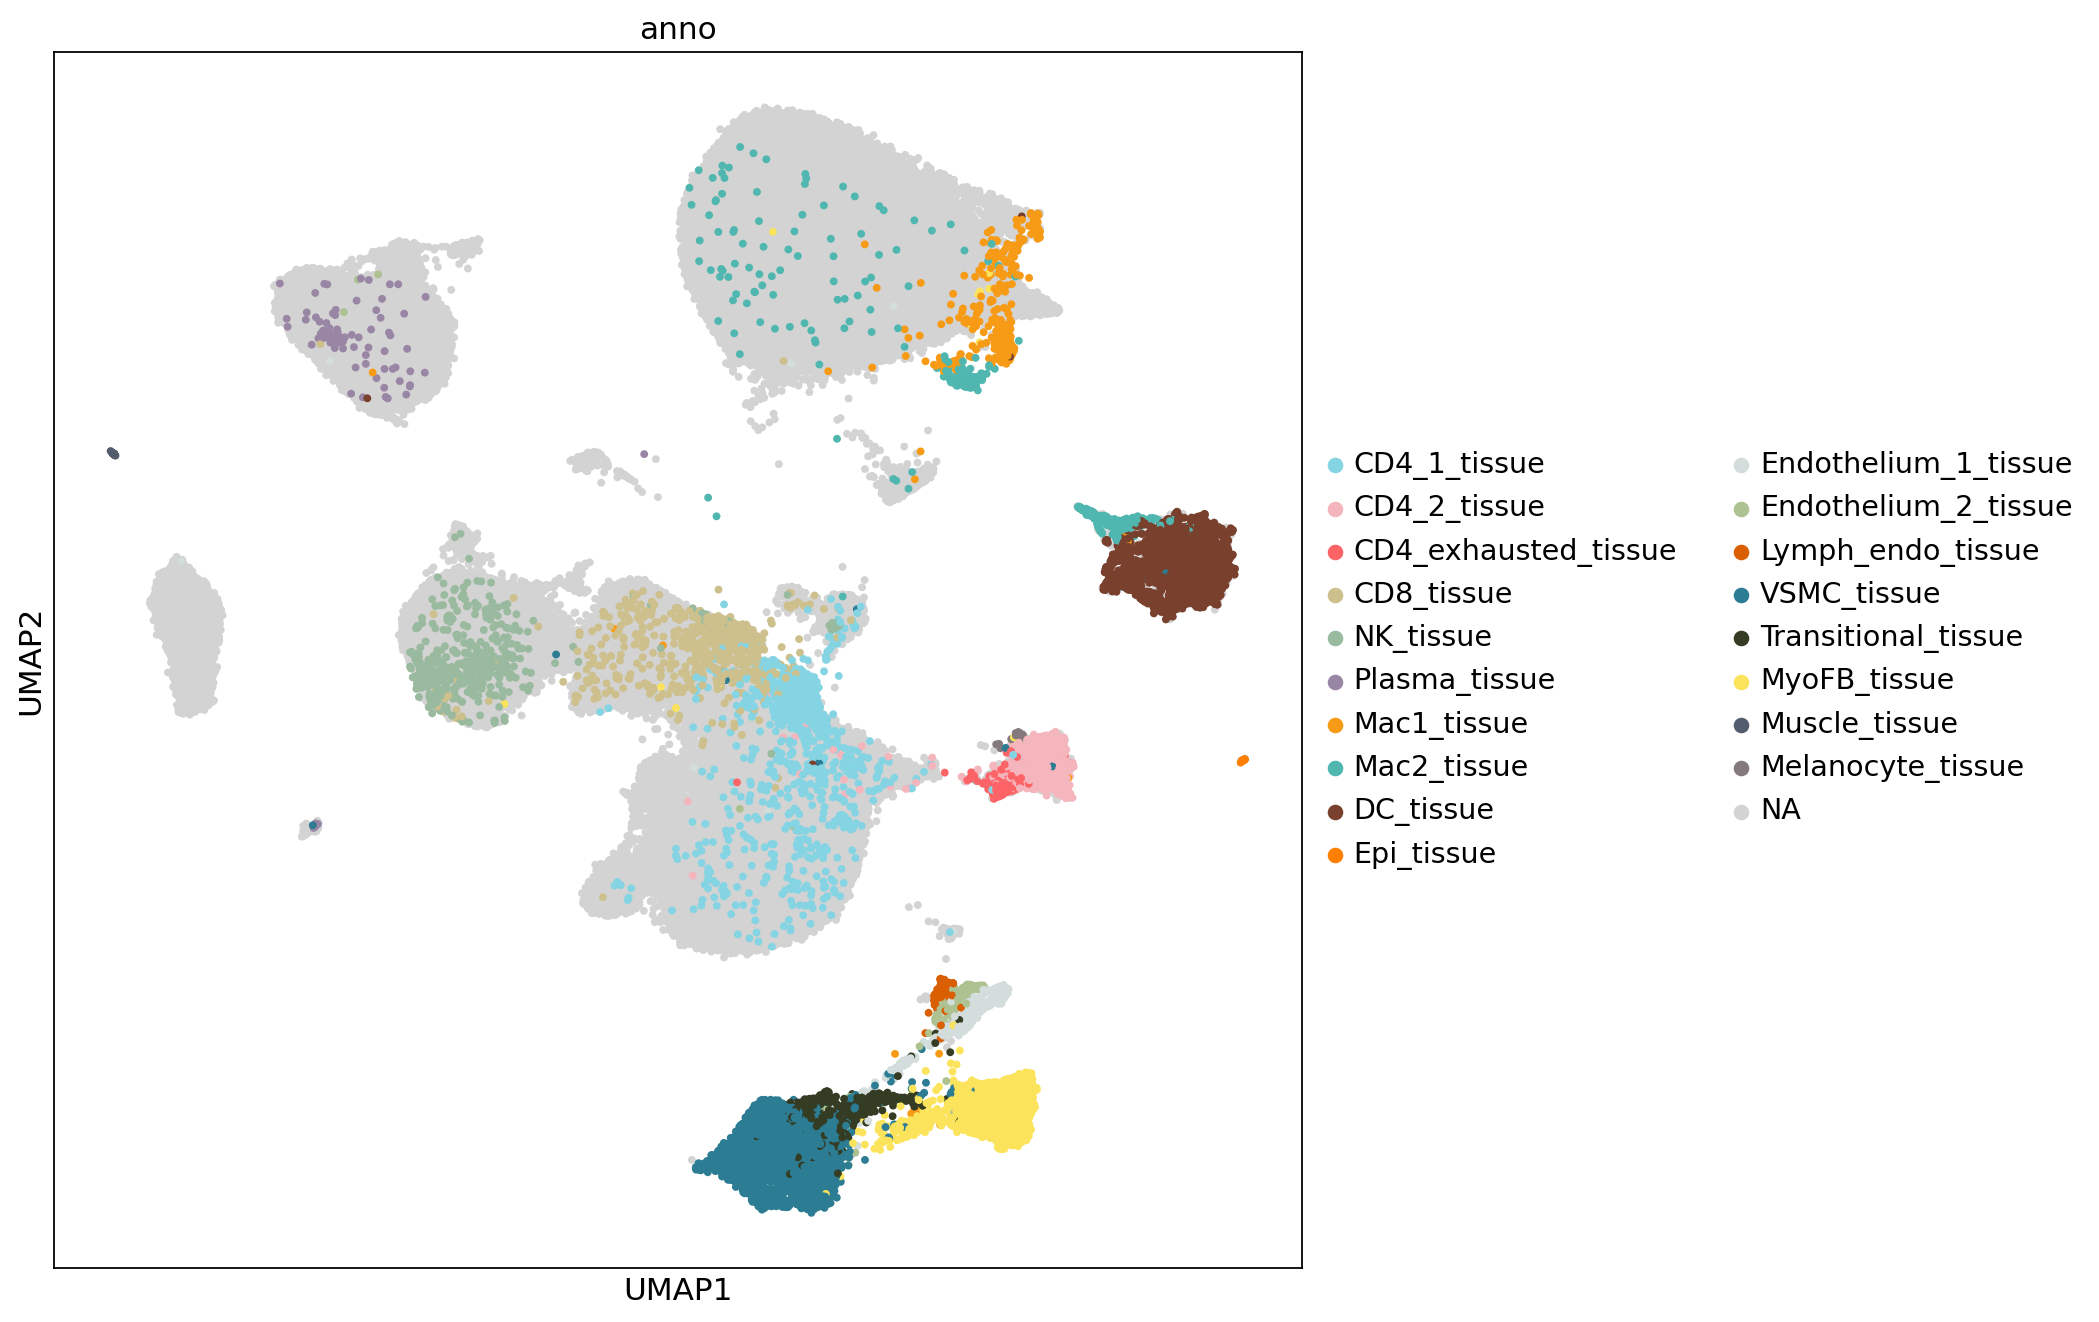

In [ ]:
sc.set_figure_params(dpi=80, dpi_save = 300)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

plt.rcParams['figure.figsize'] = [10, 10]
sc.pl.umap(gca_filtered, color=['anno'], legend_loc = 'right margin', size = 50, 
           groups = gca.obs.anno.cat.categories[gca.obs.anno.cat.categories.str.contains('_tissue')].tolist(), 
#       save = 'tissue_clusters_umap.png'
       )

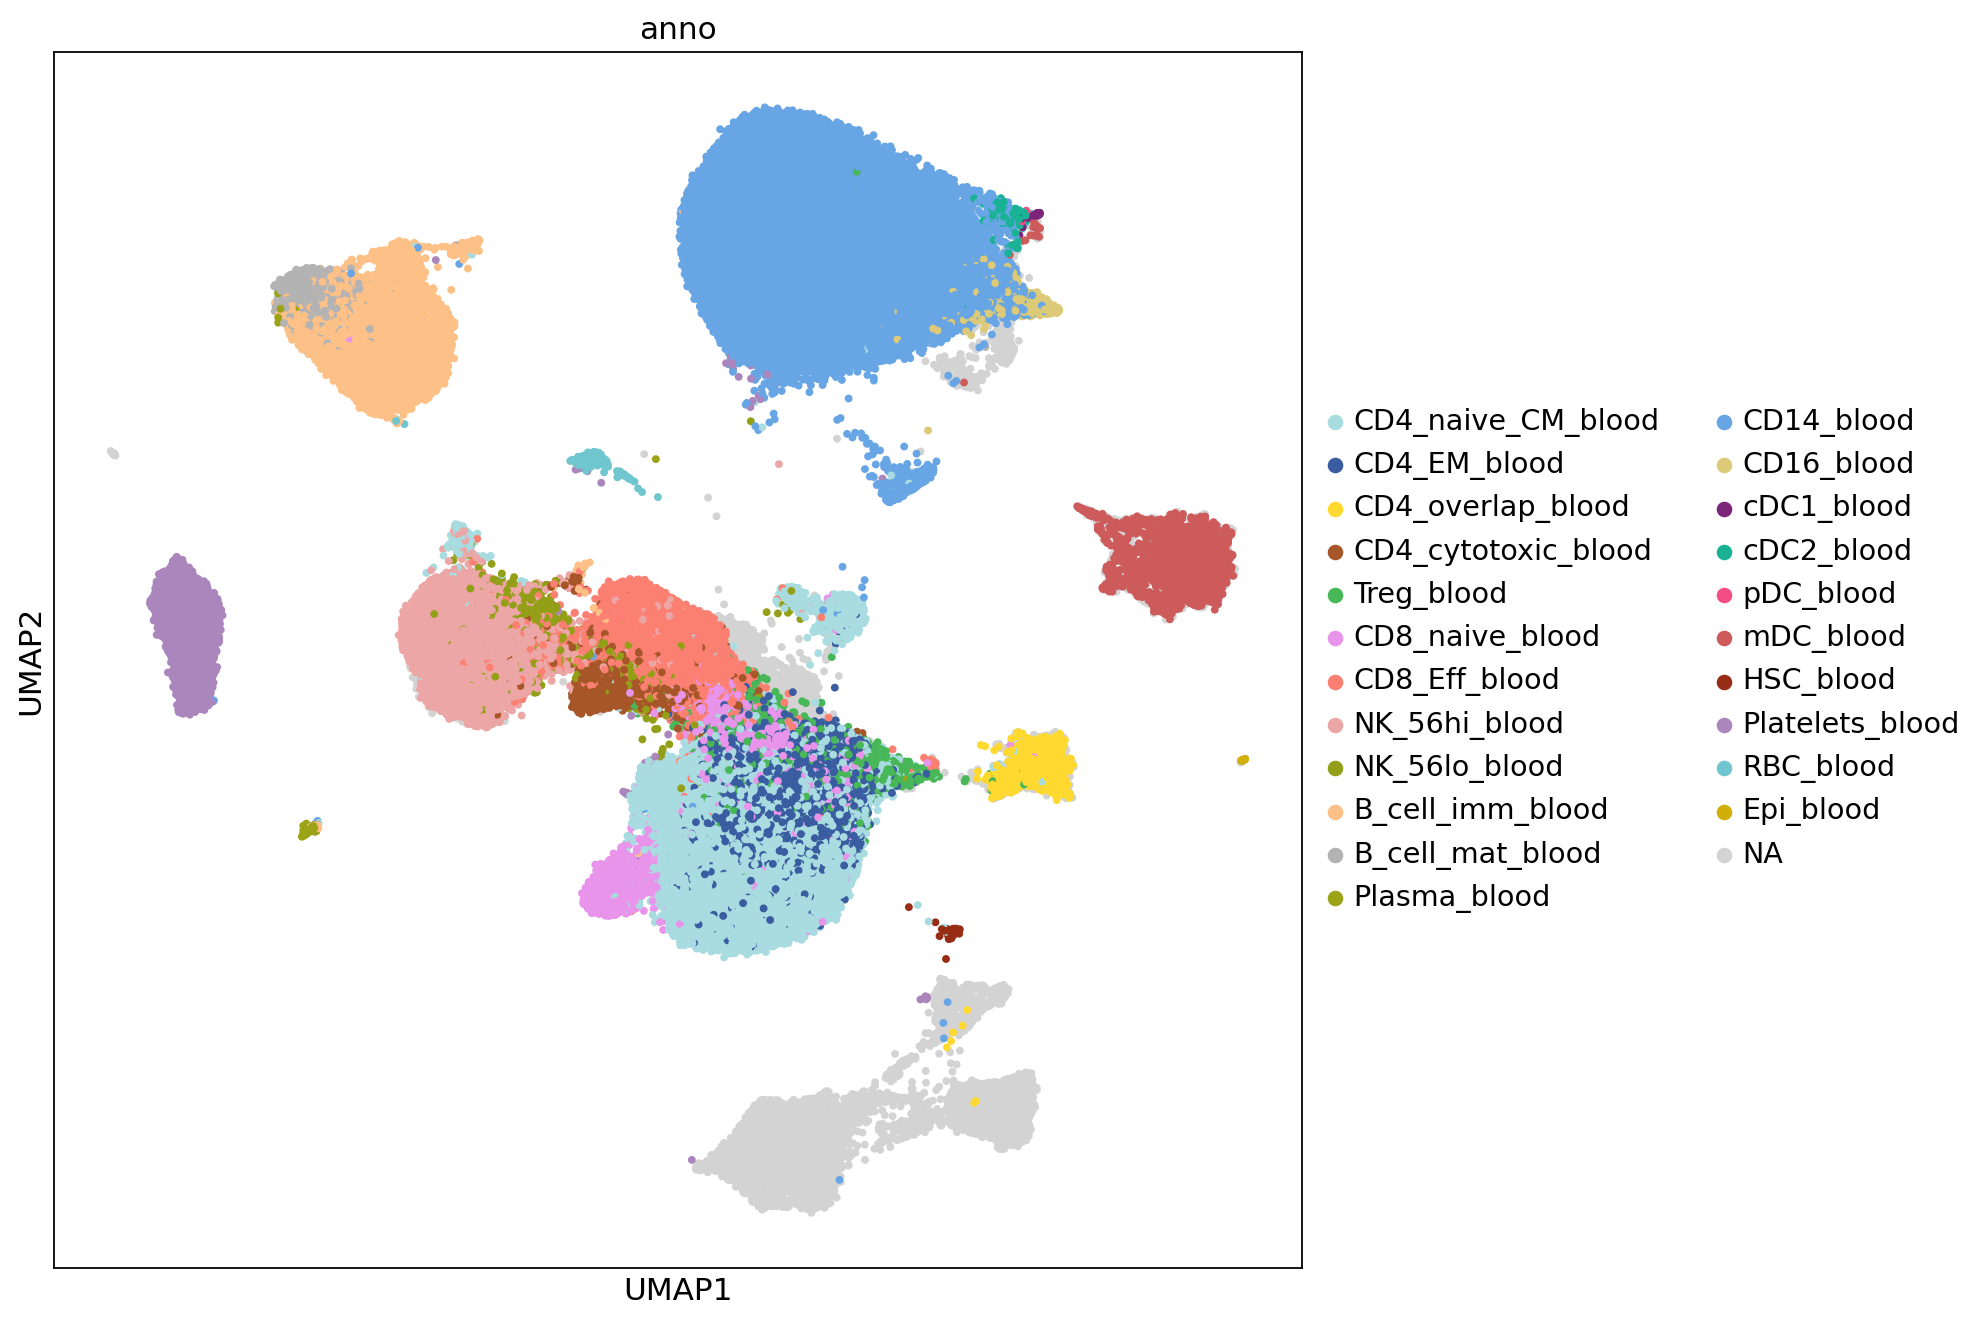

In [ ]:
sc.set_figure_params(dpi=80, dpi_save = 300)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

plt.rcParams['figure.figsize'] = [10, 10]
sc.pl.umap(gca_filtered, color=['anno'], legend_loc = 'right margin', size = 50, 
           groups = gca.obs.anno.cat.categories[gca.obs.anno.cat.categories.str.contains('_blood')].tolist(), 
     save = 'blood_clusters_umap.png'
       )

In [ ]:
#checkpoint - save annotation
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
gca.obs[['anno']].to_csv('anno.csv')
